**Pull in one grid cell from a CMIP6 model and run through rolling cdf test**

In [1]:
import intake
import xarray as xr
import os 
import pandas as pd
import numpy as np
import zarr 
import rhg_compute_tools.kubernetes as rhgk

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
write_direc = '../figures/'

In [4]:
client, cluster = rhgk.get_big_cluster()
cluster.scale(30)

In [5]:
client

Client Scheduler: gateway://traefik-impactlab-hub-dask-gateway.impactlab-hub:80/impactlab-hub.0db0d252657546be8e5d55fcfa991c89 Dashboard: /services/dask-gateway/clusters/impactlab-hub.0db0d252657546be8e5d55fcfa991c89/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [69]:
cluster.close()

get some CMIP6 data from GCS. 

here we're going to get daily `tmax` from `IPSL` for historical and SSP370 runs. The ensemble member `r1i1p1f1` isn't available in GCS so we're using `r4i1p1f1` instead. 

Note that the `activity_id` for historical runs is `CMIP`, not `ScenarioMIP` as it is for the ssp-rcp scenarios. 

In [6]:
activity_id = 'ScenarioMIP'
experiment_id = 'ssp370'
table_id = 'day'
variable_id = 'tasmax'
source_id = 'ACCESS-ESM1-5' # 'IPSL-CM6A-LR'
institution_id = 'NCAR'
member_id = 'r1i1p1f1'

look at options first

In [7]:
df_cmip6 = pd.read_csv('https://cmip6.storage.googleapis.com/cmip6-zarr-consolidated-stores-noQC.csv', dtype={'version': 'unicode'})
len(df_cmip6)

488943

In [8]:
df_subset_future = df_cmip6.loc[(df_cmip6['activity_id'] == activity_id) & (df_cmip6['experiment_id'] == experiment_id) 
             & (df_cmip6['table_id'] == table_id) & (df_cmip6['variable_id'] == variable_id)
             & (df_cmip6['source_id'] == source_id) & (df_cmip6['member_id'] == member_id)]

In [9]:
df_subset_future

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,status,severity,issue_url
372447,ScenarioMIP,CSIRO,ACCESS-ESM1-5,ssp370,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1...,NaN,20191115,good,none,none


In [10]:
df_subset_hist = df_cmip6.loc[(df_cmip6['experiment_id'] == 'historical') 
             & (df_cmip6['table_id'] == table_id) & (df_cmip6['variable_id'] == variable_id) 
             & (df_cmip6['source_id'] == source_id) & (df_cmip6['member_id'] == member_id)]

In [11]:
df_subset_hist

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version,status,severity,issue_url
372698,CMIP,CSIRO,ACCESS-ESM1-5,historical,r1i1p1f1,day,tasmax,gn,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/hist...,NaN,20191115,good,none,none


Now actually pull the data

In [12]:
# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

cat = col.search(activity_id=['CMIP', activity_id], 
                 experiment_id=['historical', experiment_id], table_id=table_id, variable_id=variable_id,
                 source_id=source_id, member_id=member_id)

In [13]:
cat

,unique
activity_id,2
institution_id,1
source_id,1
experiment_id,2
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,2
dcpp_init_year,0


In [21]:
cat['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn']

,variable_id,zstore,member_id
0,tasmax,gs://cmip6/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/day/tasmax/gn/v20191115/,r1i1p1f1


In [22]:
ds_model = {}
ds_model['historical'] = cat['CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

Define the historical and simulated datasets

In [23]:
hist_ds = ds_model['historical']
hist_ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 60265)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(582, 145, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    0.0
    branch_time_in_parent:   21915.0
    cmor_version:            3.4.0
    creation_date:           2019-11-15T17:28:16Z
    data_specs_version:      01.00.30
    experiment:              all-forcing simulation of the recent past
    experiment_id:           historical
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    grid_label:              gn
    history:                 2019-11-15T17:28:16Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Commonwealth Scientific and Industrial Research ...
    institution_id:          CSIRO
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: ESM-historical; Local ID: HI-05; Variable: ...
    parent_activity_id:      CMIP
    parent_experiment_id:    piControl
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-ESM1-5
    parent_time_units:       days since 0101-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    source_id:               ACCESS-ESM1-5
    source_type:             AOGCM
    status:                  2020-06-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:             hdl:21.14100/67543e90-bb83-44b1-8a30-e1fbb5ada0d...
    variable_id:             tasmax
    variant_label:           r1i1p1f1
    version:                 v20191115
    intake_esm_varname:      ['tasmax']
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.day.gn

In [27]:
ds_model['ssp370'] = cat['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn'].to_dask().isel(member_id=0
                                                                                       ).squeeze(drop=True).drop(['member_id',
                                                                                                                  'height'])

In [28]:
sim_ds = ds_model['ssp370']
sim_ds

<xarray.Dataset>
Dimensions:  (lat: 145, lon: 192, time: 31411)
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * time     (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(583, 145, 192), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP AerChemMIP
    branch_method:           standard
    branch_time_in_child:    60265.0
    branch_time_in_parent:   60265.0
    cmor_version:            3.4.0
    creation_date:           2019-11-15T10:38:50Z
    data_specs_version:      01.00.30
    experiment:              gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:           ssp370
    external_variables:      areacella
    forcing_index:           1
    frequency:               day
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.CSIRO.ACCES...
    grid:                    native atmosphere N96 grid (145x192 latxlon)
    grid_label:              gn
    history:                 2019-11-15T10:38:50Z ; CMOR rewrote data to be c...
    initialization_index:    1
    institution:             Commonwealth Scientific and Industrial Research ...
    institution_id:          CSIRO
    license:                 CMIP6 model data produced by CSIRO is licensed u...
    mip_era:                 CMIP6
    nominal_resolution:      250 km
    notes:                   Exp: ESM-ssp370; Local ID: SSP-370-05; Variable:...
    parent_activity_id:      CMIP
    parent_experiment_id:    historical
    parent_mip_era:          CMIP6
    parent_source_id:        ACCESS-ESM1-5
    parent_time_units:       days since 1850-1-1
    parent_variant_label:    r1i1p1f1
    physics_index:           1
    product:                 model-output
    realization_index:       1
    realm:                   atmos
    run_variant:             forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2...
    source:                  ACCESS-ESM1.5 (2019): \naerosol: CLASSIC (v1.0)\...
    source_id:               ACCESS-ESM1-5
    source_type:             AOGCM
    status:                  2020-06-24;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:          none
    sub_experiment_id:       none
    table_id:                day
    table_info:              Creation Date:(30 April 2019) MD5:e14f55f257ccea...
    title:                   ACCESS-ESM1-5 output prepared for CMIP6
    tracking_id:             hdl:21.14100/701b06d0-3da1-47c4-a2ed-4635778cb16...
    variable_id:             tasmax
    variant_label:           r1i1p1f1
    version:                 v20191115
    intake_esm_varname:      ['tasmax']
    intake_esm_dataset_key:  ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp370.day.gn

Pull in tasmax from ERA-5 for the reference dataset from 1995-2014

In [29]:
# Per decade analysis
filenames = []

yrs = np.arange(1995,2015) 
    
for num_yrs in range(len(yrs)):
    filename = '/gcs/impactlab-data/climate/source_data/ERA-5/day/tmax/v1.1/tmax_daily_{}-{}.nc'.format(yrs[num_yrs], yrs[num_yrs])
    filenames.append(filename)
    
era5_tmax = xr.open_mfdataset(filenames, concat_dim='time', combine='by_coords')
print('Loading ERA5 files...')
print(era5_tmax['tmax'])

Loading ERA5 files...
<xarray.DataArray 'tmax' (time: 7305, latitude: 721, longitude: 1440)>
dask.array<concatenate, shape=(7305, 721, 1440), dtype=float32, chunksize=(366, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31


In [30]:
ref_ds = era5_tmax
ref_ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 7305)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31
Data variables:
    tmax       (time, latitude, longitude) float32 dask.array<chunksize=(365, 721, 1440), meta=np.ndarray>
Attributes:
    author:   Meredith Fish
    contact:  meredith.fish@rutgers.edu
    project:  impactlab-rhg/climate/source-data/ERA-5
    source:   impactlab-rhg/climate/downscaled/ERA-5/hourly
    created:  2021-02-16

In [49]:
# Select a single grid point for analysis -- Miami, FL
lat = 25.78
lon = 280.0

ref_da = ref_ds['tmax'].sel(latitude=lat, longitude=lon, method='nearest')
hist_da = hist_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest') # narrow the time
sim_da = sim_ds['tasmax'].sel(lat=lat, lon=lon, method='nearest')

In [51]:
hist_da = hist_da.sel(time=slice('1995-01-01','2014-12-31'))
hist_da

<xarray.DataArray 'tasmax' (time: 7305)>
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(582,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 26.25
    lon      float64 279.4
  * time     (time) datetime64[ns] 1995-01-01T12:00:00 ... 2014-12-31T12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: mean time: maximum
    comment:        maximum near-surface (usually, 2 meter) air temperature (...
    history:        2019-11-15T17:28:16Z altered by CMOR: Treated scalar dime...
    long_name:      Daily Maximum Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K

In [55]:
ref_da

<xarray.DataArray 'tmax' (time: 7305)>
dask.array<getitem, shape=(7305,), dtype=float32, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
    longitude  float32 280.0
    latitude   float32 25.75
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31

In [57]:
def remove_leap_days(da):
    noleap = da.where(~((da.time.dt.month == 2) & 
                        (da.time.dt.day == 29)), drop=True)
    
    years = np.arange(da.time.dt.year.min(),da.time.dt.year.max()+1)
    if len(da.time) == len(np.arange(1,366))*len(years):
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(np.array([np.arange(1,366)]*len(years)).flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
    else:
        # adjust years to leave off last (not-full) year
        years = np.arange(da.time.dt.year.min(),da.time.dt.year.max())
        # create full year time array
        time_array = np.array([np.arange(1,366)]*len(years))
        # creat datenum for last year (if first year, change to min)
        last_yr = [np.arange(1,len(da['time'].sel(time=str(da.time.dt.year.max().values)))+1)]*1
        # combine to one new time array
        all_time = np.append(time_array, last_yr)
        
        noleap = noleap.assign_coords(dayofyear=xr.DataArray(all_time.flatten(),
                                                dims=('time'),
                                                coords={'time':noleap.time})).persist()
        
    return noleap

In [58]:
ref = remove_leap_days(ref_da)
hist = remove_leap_days(hist_da)
sim = remove_leap_days(sim_da)

In [61]:
ref = ref.load()
hist = hist.load()
sim = sim.load()

In [62]:
ref

<xarray.DataArray 'tmax' (time: 7300)>
array([296.9492 , 297.23203, 297.05908, ..., 298.15082, 298.14618,
       298.03348], dtype=float32)
Coordinates:
    longitude  float32 280.0
    latitude   float32 25.75
  * time       (time) datetime64[ns] 1995-01-01 1995-01-02 ... 2014-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365

In [59]:
#chunks = {'time': -1}

#ref = ref.chunk(chunks).persist()
#hist = hist.chunk(chunks).persist()
#sim = sim.chunk(chunks).persist()

Load necessary packages, etc. for QDM implementation

In [38]:
! pip install git+https://github.com/ClimateImpactLab/xclim.git@qdm_add_year_selection

  Cloning https://github.com/ClimateImpactLab/xclim.git (to revision qdm_add_year_selection) to /tmp/pip-req-build-6t4j9683


In [39]:
%matplotlib inline
import scipy as sp
import matplotlib.pyplot as plt
import dask
import dask.array as da
import dask.distributed as dd
import xclim
from xclim import sdba
from scipy.stats import scoreatpercentile
from scipy.stats.kde import gaussian_kde

from xclim.testing.tests.test_sdba import utils as tu

In [40]:
write_direc = '../figures/'

In [41]:
nquantiles = 100 #620 is empirical
kind = "+" #"*" #"+"

if kind=='*':
    kindstr='mult'
else:
    kindstr='add'

In [63]:
grouper = "time.dayofyear"
window = 31 

grouper = sdba.Grouper(grouper, window=window)

QMdg = sdba.adjustment.EmpiricalQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QMdg.train(ref, hist) #(ref, hist)  

DQMdg = sdba.adjustment.DetrendedQuantileMapping(kind=kind, group=grouper, nquantiles=nquantiles)
DQMdg.train(ref, hist)

QDMdg = sdba.adjustment.QuantileDeltaMapping(kind=kind, group=grouper, nquantiles=nquantiles)
QDMdg.train(ref, hist)

In [64]:
hist_qdm = QDMdg.adjust(hist)
sim_qdm = QDMdg.adjust(sim)

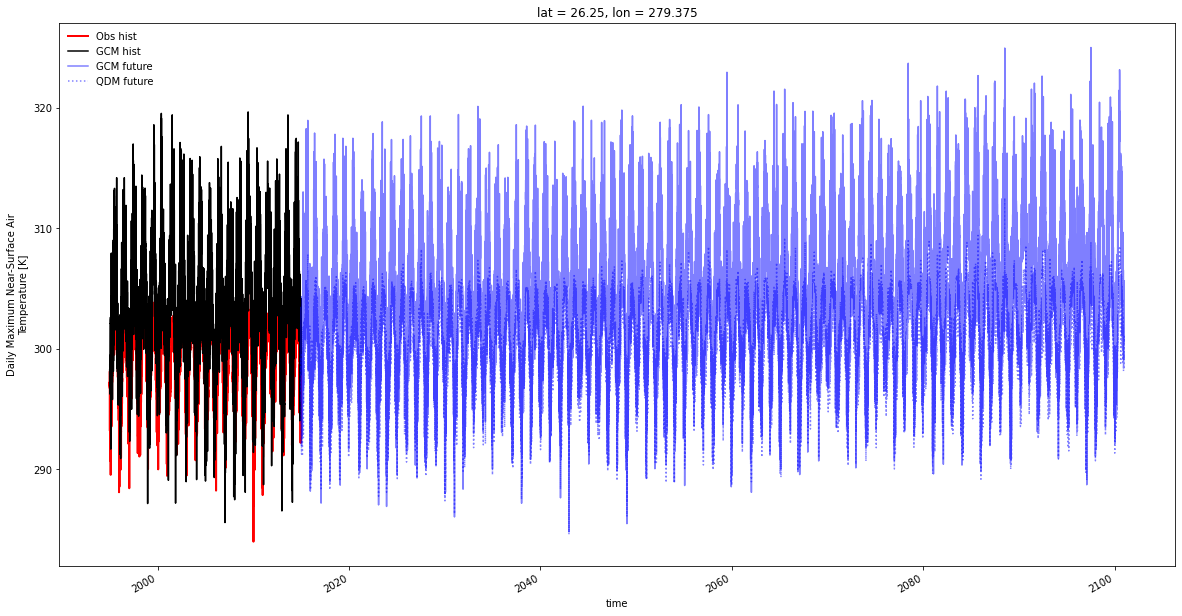

In [65]:
fig,ax = plt.subplots(1,1,figsize=(20,10))
ref.plot(ax=ax, linewidth=2, color="r", label="Obs hist")
hist.plot(ax=ax, color="k", label="GCM hist")
sim.plot(ax=ax, color="blue", label="GCM future", alpha=.5)
#simtrend.plot(ax=ax, color="cyan", label="GCM future trend", alpha=.5)
sim_qdm.plot(ax=ax, linestyle=':', color="blue", label="QDM future", alpha=.5)
#simtrend_qdm.plot(ax=ax, linestyle=':', color="cyan", label="QDM future trend", alpha=.5)
ax.legend(frameon=False)

In [66]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change

all days linear trend
  sim     4.269448767277197
  QDM sim 1.792552091723907


**Rolling CDF**

In [67]:
simy_qdm_list = []
#simtrendy_qdm_list = []

roll = 10

# because we're rolling, we can't use the first and last 10 years
bc_years = np.arange(sim.time.dt.year.values[0]+roll,sim.time.dt.year.values[-1]-roll)

for yr in bc_years:
    print(yr)
    timeslice = slice(str(yr-roll),str(yr+roll))
    
    # testing this on a future with a trend and one without
    simy_qdm_list.append(QDMdg.adjust(sim.sel(time=timeslice), year=yr)) 
#    simtrendy_qdm_list.append(QDMdg.adjust(simtrend.sel(time=timeslice), year=yr)) 

simy_qdm = xr.concat(simy_qdm_list, dim='time')
#simtrendy_qdm = xr.concat(simtrendy_qdm_list, dim='time')

2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089


In [68]:
print('all days linear trend')
print('  sim    ', sp.stats.linregress(np.arange(len(sim.time)), sim.values).slope*len(sim.time)) # total change
print('  QDM sim', sp.stats.linregress(np.arange(len(sim_qdm.time)), sim_qdm.values).slope*len(sim_qdm.time)) # total change

all days linear trend
  sim     4.269448767277197
  QDM sim 1.792552091723907


**Are the trends preserved across quantiles?**

In [ ]:
from plotting import quantile_compare_plot, compare_quantile_deltas_scatter_hist, compare_gcm_qdm_quantile_deltas

In [ ]:
# what are the best keys to use? 'GCM hist', 'QDM hist', 'GCM future','QDM future' or what is here?
raw_dict = {'ref':ref,
           'hist':hist,
           'sim':sim}
adjusted_dict = {'hist':hist_qdm,
                'sim':sim_qdm}
bcgrouper = QDMdg.group